# Shampoo sale - série temporal

Esse projeto tem como objetivo analisar uma base de dados de venda de shampoos com tendência ascendente, criar e avaliar um modelo de série temporal clássico para prever próximos pontos dessa amostra.

Para esse fim, o relatório é dividido em três etapas:
1. Tratamento da base de dados
2. Modelagem
3. Previsão e avaliação do modelo

# 1. Tratamento da base de dados

O objetivo do tratamento de dados é garantir que a base esteja pronta para rodar modelos de séries temporais e criar previsões. Para isso, a série passou por um processo de diferenciação e os gráficos ACF e PACF foram analisados para compreender o comportamento da base.

De acordo com a análise, o melhor modelo para essa série é um autoregressivo, pois o lag-1 do ACF é uma autocorrelação positiva e os lags decaem bruscamente e não gradualmente, tanto no ACF como no PACF. Além disso, ambos os gráficos mostram dois lags dignificativos, portanto, o componente autoregressivo do modelo é p=2.
Como a série sofreu uma diferenciação, d=1. E, como geralmente séries autoregressivas não possuem um componente de média móvel, q=0.

Assim, temos ARIMA(2, 1, 0) como modelo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

In [11]:
df = pd.read_csv('shampoo.csv', sep=',')
df.shape

(36, 2)

In [12]:
df.index = df['Month']
df = df.drop(['Month'], axis=1)
df.head()

,Sales
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


In [13]:
sns.set(rc={'figure.figsize':(15, 6)})

<AxesSubplot:xlabel='Month'>

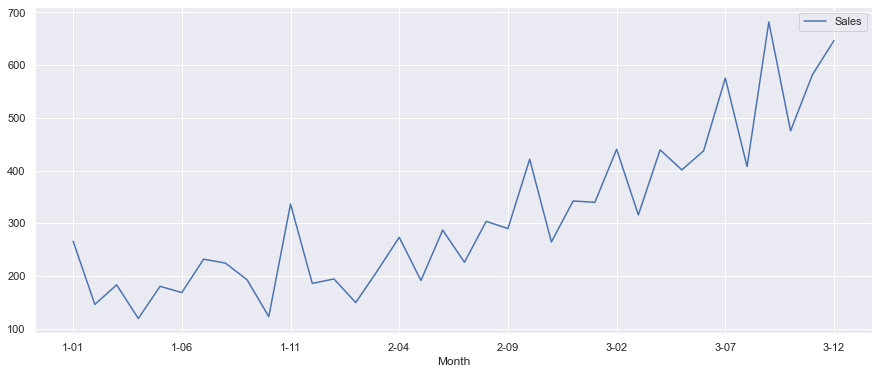

In [14]:
df.plot()

In [15]:
# maior que 0.05, ou seja, precisa de diferenciação
ad_fuller_result = adfuller(df)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 3.0601420836411806
p-value: 1.0


In [16]:
df['1D'] = df['Sales'].diff().fillna(0)
df.head()

,Sales,1D
Month,,
1-01,266.0,0.0
1-02,145.9,-120.1
1-03,183.1,37.2
1-04,119.3,-63.8
1-05,180.3,61.0


In [17]:
# estacionária e pronta para modelar
ad_fuller_result = adfuller(df['1D'].fillna(0))
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.970942831118072
p-value: 8.668351537532444e-10


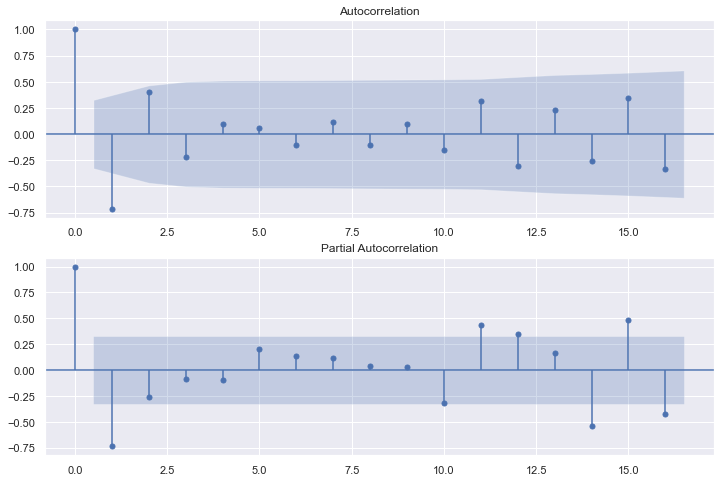

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['1D'].values.squeeze(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['1D'], ax=ax2)

In [19]:
train, test = train_test_split(df['1D'], train_size=0.75, shuffle=False)
print("train: ", train.shape)
print("test: ", test.shape)

train:  (27,)
test:  (9,)


# 2. Modelagem

Aqui, roda-se o modelo ARIMA(2, 1, 0) na série temporal.

In [22]:
mod = sm.tsa.arima.ARIMA(train, order=(2, 1, 0))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                     1D   No. Observations:                   27
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -154.582
Date:                Wed, 27 Oct 2021   AIC                            315.164
Time:                        11:11:06   BIC                            318.938
Sample:                             0   HQIC                           316.250
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0580      0.233     -4.532      0.000      -1.515      -0.600
ar.L2         -0.2976      0.263     -1.132      0.258      -0.813       0.218
sigma2      8143.7033   2401.315      3.391      0.0

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


# 3. Previsão e avaliação do modelo

O diagnóstico do modelo mostra que o modelo ainda pode ser aprimorado. Isso porque o histograma não apresenta uma distribuição normal, a série tem pontos de autocorrelação sognificativos e os resíduos não estão uniformes como deveriam. Além disso, a porcentagem de erro da previsão dos dados é 86%, muito alta para um modelo.

<Figure size 1080x864 with 0 Axes>

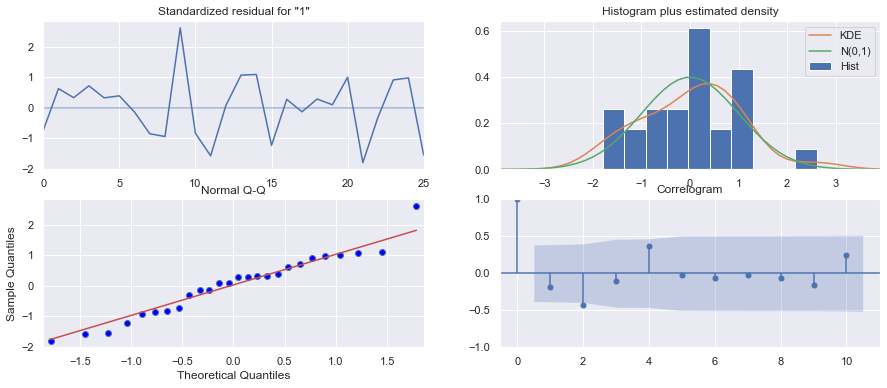

<Figure size 1080x864 with 0 Axes>

In [23]:
res.plot_diagnostics()
plt.figure(figsize=(15, 12))

In [25]:
forecast = res.forecast(9)
forecast.head()

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


27    83.017167
28   -69.516320
29    30.107535
30   -29.901150
31     3.940469
Name: predicted_mean, dtype: float64

In [26]:
rmse = sqrt(mean_squared_error(test, forecast))
rmse

150.1293644813654

In [27]:
mae = mean_absolute_error(test, forecast)
mae

121.781900316854

In [28]:
mape = mean_absolute_percentage_error(test, forecast)
mape

0.865563291081927